#  도구(Tool) 추가

챗봇이 "기억만으로" 답변할 수 없는 질문을 처리하기 위해서 `웹 검색 도구`를 사용하도록 합니다. 챗봇은 이 도구를 사용하여 관련 정보를 찾고 더 나은 답변을 제공할 수 있습니다.

## 필수 조건

이번 튜토리얼에서는 웹 검색도구로 `Tavily 검색 엔진`을 사용합니다. [Tavily 검색 엔진](https://python.langchain.com/docs/integrations/tools/tavily_search/)을 위한 API 키를 등록하세요. 

In [31]:
"""
# OPENAI API KEY
OPENAI_API_KEY={your-open-api-key-here}

# GOOGLE API KEY
GOOGLE_GENAI_USE_VERTEXAI=FALSE
GOOGLE_API_KEY={your-google-api-key-here}

# ANTHROPIC API KEY
ANTHROPIC_API_KEY={your-anthropic-api-key-here}
 
# LANGCHAIN TOOL
TAVILY_API_KEY={your-tavily-api-key-here}

# LangSmith 설정
LANGCHAIN_TRACING_V2=false
LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
LANGCHAIN_API_KEY={your-langchain-api-key-here}
LANGCHAIN_PROJECT={your-project-name-here}
"""

'\n# OPENAI API KEY\nOPENAI_API_KEY={your-open-api-key-here}\n\n# GOOGLE API KEY\nGOOGLE_GENAI_USE_VERTEXAI=FALSE\nGOOGLE_API_KEY={your-google-api-key-here}\n\n# ANTHROPIC API KEY\nANTHROPIC_API_KEY={your-anthropic-api-key-here}\n\n# LANGCHAIN TOOL\nTAVILY_API_KEY={your-tavily-api-key-here}\n\n# LangSmith 설정\nLANGCHAIN_TRACING_V2=false\nLANGCHAIN_ENDPOINT=https://api.smith.langchain.com\nLANGCHAIN_API_KEY={your-langchain-api-key-here}\nLANGCHAIN_PROJECT={your-project-name-here}\n'

## 1. 패키지 설치

In [32]:
pip install -qU langchain-tavily

Note: you may need to restart the kernel to use updated packages.


In [33]:
# 환경 변수 확인
from dotenv import load_dotenv
import os
load_dotenv(override=True)

TAVILY_API_KEY= os.environ.get("TAVILY_API_KEY")
print(TAVILY_API_KEY[:20])

tvly-dev-GUT1o6jP4Og


## 2. 도구 정의

웹 검색을 위한 도구를 정의합니다.

In [34]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("2024 한국 프로야구 우승팀을 알려줘")

{'query': '2024 한국 프로야구 우승팀을 알려줘',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://blog.naver.com/travelguide_94/223637975869',
   'title': '2024 프로야구 한국시리즈 우승팀은 기아 타이거즈! KBO 최종 순위 정보',
   'content': '... 우승은. 7년 만의 통합 우승인. 기아 타이거즈가 가져가게 되었는데요. 내년에는 과연 어떤 팀이. 우승을 할지도 궁금해지네요:) \u200b. 결론,. 야구 쪼오온잼',
   'score': 0.85567063,
   'raw_content': None},
  {'url': 'https://namu.wiki/w/2024%20%EC%8B%A0%ED%95%9C%20SOL%20Bank%20KBO%20%ED%95%9C%EA%B5%AD%EC%8B%9C%EB%A6%AC%EC%A6%88',
   'title': '2024 신한 SOL Bank KBO 한국시리즈 - 나무위키',
   'content': '2024 프로야구 챔피언, KBO 최다 우승팀, 열두 번째 우승, KIA 타이거즈! 최초의 80년대생 감독 이범호 감독은 팬들에게 했던 우승의 약속을 지켰고, KBO 리그의',
   'score': 0.7750779,
   'raw_content': None}],
 'response_time': 1.08}

## 3. 그래프 정의

LLM이 검색 도구를 사용할 수 있도록 `bind_tools()` 함수를 사용하여 등록합니다.

In [35]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

def chatbot(state: State):
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    # 수정: LLM이 검색 엔진을 사용할 수 있도록 LLM에게 알려줍니다. 
    llm_with_tools = llm.bind_tools(tools)
    
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

graph_builder.add_node("chatbot", chatbot)

## 4. 도구 실행을 위한 함수 

In [36]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """마지막 AIMessage에서 요청한 도구를 실제로 실행하는 노드"""

    def __init__(self, tools: list) -> None:
        # 도구의 이름으로 도구를 찾을 수 있도록 준비한다.
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # Python 3.8 이상에서 도입된 "할당 표현식"
        # :=를 사용하면 한 줄로 조건 검사와 변수 할당을 동시에 할 수 있습니다.
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        outputs = []
        for tool_call in message.tool_calls:
            # 도구 실행
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


# 도구 실행 노드를 그래프에 추가한다.
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

앞으로 도구 실행 노드를 직접 만들지 않고, LangGraph에서 미리 만들어둔 [ToolNode](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.tool_node.ToolNode)를 사용합니다.


## 조건부 엣지(Conditional Edge) 추가

엣지(edges)는 하나의 노드에서 다음 노드로 제어 흐름(control flow) 을 전달합니다.
조건부 엣지(conditional edges) 는 하나의 노드에서 시작되며, 현재 그래프 상태에 따라 서로 다른 노드로 이동하기 위해 보통 "if" 문을 포함합니다.  
  
이러한 함수들은 현재의 그래프 상태를 받아서, 다음에 실행할 노드 이름(문자열 또는 문자열 리스트)을 반환합니다.

이제 `route_tools` 라는 `라우터 함수(router function)` 를 정의합니다. 이 함수는 챗봇의 출력에 `tool_calls`가 포함되어 있는지를 확인합니다.
이 함수를 그래프에 전달하기 위해 `add_conditional_edges` 를 사용하며,이 함수는 챗봇 노드가 완료된 후 어느 노드로 이동할지 결정할 때 호출됩니다.

조건은 다음과 같은 흐름을 따릅니다:
- tool_calls가 존재하면 → tools 노드로 이동
- 없다면 → END로 이동

이 조건 함수가 END를 반환할 수 있기 때문에, 이번에는 별도로 finish_point를 명시하지 않아도 됩니다.

In [37]:
def route_tools(state: State):
    """
    조건부 엣지에서 마지막 메시지에 tool_calls가 있으면 ToolNode로 라우팅하고,그렇지 않으면 END로 라우팅합니다.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # tool_calls가 있고, 하나 이상일때 "tools"를 리턴
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고,
# 바로 응답해도 되는 경우에는 "END"를 반환합니다.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # `route_tools`에서 'tools'문자열이 리턴되면 'tools'노드로 이동, END가 리턴되면 END노드로 이동한다.
    {"tools": "tools", END: END},
)

# 도구가 호출될 때마다, 다음 단계를 결정하기 위해 다시 챗봇으로 돌아갑니다.
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

이 부분은 LangGraph에서 제공하는 [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) 을 사용하면 간격하게 작성할 수 있다.

## 5. 시각화

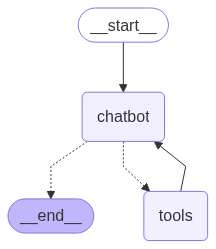

In [38]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 6. 챗봇 실행

In [39]:
# You can exit the chat loop at any time by typing `quit`, `exit`, or `q`.

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("또 만나요!")
            break
        stream_graph_updates(user_input)
    except:
        # input()을 사용할 수 없는 경우의 대체 처리(fallback)
        user_input = "지구에서 달까지의 거리를 알려줘?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  


Assistant: Hello! How can I assist you today?


User:  2024 미국 대선결과를 알려줘


Assistant: 
Assistant: {"query": "2024 \ubbf8\uad6d \ub300\uc120 \uacb0\uacfc", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.axios.com/2025/06/26/trump-harris-latino-voters-2024-election-pew", "title": "Trump came close to winning Latino vote in '24 \u2014 Pew analysis - Axios", "score": 0.6453216, "published_date": "Thu, 26 Jun 2025 14:24:59 GMT", "content": "President Trump won a higher percentage of the Latino vote in 2024 than previously believed and came within striking distance of capturing a historic majority of those voters, according to a new Pew Research Center analysis of the election results. **The big picture:** Pew's analysis of election data shows that Trump won 48% of Latino voters \u2014 a group that had soundly rejected him in 2020 and 2016 \u2014 and that it was a crucial factor in his victory. *   Hispanics were a growing share of Trump's support while white non-Latino voters were a declining share, or a smaller share, 

User:  exit


또 만나요!


## 7. ToolNode, tool_condition 사용하기

- `BasicToolNode`는  [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode)로 사용
- `route_tools`는  [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition)로 사용

In [ ]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]

def chatbot(state: State):
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    llm_with_tools = llm.bind_tools(tools)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

# 📌 ToolNode 추가
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# 
graph_builder.add_conditional_edges(
    "chatbot",
    # 📌 "tools" 또는 END를 리턴한다.
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()